In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:
INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/"
OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/af_depth/"

In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

fig_utils from mplh
here
0.5.6


In [4]:
#glob("/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/cells_meta.tsv")

In [5]:
out_f = join(OUTDIR, "af_depth")

In [6]:
in_dirs = glob(INDIR+"clones_init/donor*")
in_dirs

afs = []
dps = []
donor_inds = {}
for don_dir in in_dirs:
    curr_af = pd.read_csv(don_dir+"/af.tsv",sep="\t", index_col=0)
    afs.append(curr_af)
    dps.append(pd.read_csv(don_dir+"/dp.tsv",sep="\t",index_col=0))
    print(afs[-1].shape)
    donor_inds[don_dir] = curr_af.columns[(curr_af>0.8).sum(axis=0)>(0.8*curr_af.shape[0])]

    print(glob(don_dir+"/af.tsv"))
    print(glob(don_dir+"/dp.tsv"))

(9023, 68)
['/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0/af.tsv']
['/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0/dp.tsv']
(8275, 68)
['/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1/af.tsv']
['/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1/dp.tsv']


In [7]:
AF_df = pd.concat(afs)
DP_df = pd.concat(dps)

In [8]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t').set_index("ID") #.sort_values(["donor", "lineage"])
cells_meta = cells_meta.dropna(axis=0, subset=["donor"])
cells_meta["donor"] = cells_meta["donor"].astype(int).astype(str)
cells_meta
curr_labels = cells_meta


## Load cluster results and plot dendrograms

In [9]:
print(AF_df.shape)
AF_df.head()

(17298, 68)


,10397G,10463C,10559G,10589A,11251G,11453A,11719A,11761T,11812G,13188T,...,750G,7598A,827G,8292A,8461T,8697A,8743A,8860G,930A,9899C
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAATCAAC-1_Control,1.0,0.0,0.0,0.882353,0.153846,0.0,0.000000,0.846154,0.054054,1.000000,...,1.0,1.000000,0.961538,0.866667,1.000000,0.0,0.0,1.0,0.0,0.000000
AAACGAAAGCGAGAAA-1_Control,1.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,0.838710,0.0,0.0,1.0,0.0,0.076923
AAACGAAAGTACAGAT-1_Control,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,0.000000
AAACGAAAGTTAGCAA-1_Control,0.8,0.0,0.0,1.000000,0.000000,0.0,0.428571,0.700000,0.000000,0.818182,...,1.0,1.000000,1.000000,0.909091,1.000000,0.5,0.0,1.0,0.0,0.250000
AAACGAACACTCGCAG-1_Control,1.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,...,1.0,0.928571,1.000000,1.000000,0.888889,0.0,0.0,1.0,0.0,0.000000


In [10]:
print(DP_df.shape)
DP_df.head()

(17298, 68)


,10397G,10463C,10559G,10589A,11251G,11453A,11719A,11761T,11812G,13188T,...,750G,7598A,827G,8292A,8461T,8697A,8743A,8860G,930A,9899C
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAATCAAC-1_Control,2.0,11.0,15.0,17.0,13.0,20.0,47.0,26.0,37.0,24.0,...,31.0,20.0,26.0,30.0,35.0,20.0,23.0,29.0,14.0,41.0
AAACGAAAGCGAGAAA-1_Control,16.0,16.0,26.0,21.0,25.0,22.0,21.0,23.0,27.0,20.0,...,15.0,14.0,25.0,44.0,31.0,19.0,23.0,32.0,29.0,26.0
AAACGAAAGTACAGAT-1_Control,1.0,3.0,5.0,6.0,5.0,11.0,11.0,17.0,14.0,16.0,...,5.0,4.0,9.0,5.0,10.0,10.0,20.0,8.0,5.0,12.0
AAACGAAAGTTAGCAA-1_Control,5.0,9.0,5.0,7.0,7.0,1.0,14.0,10.0,7.0,11.0,...,6.0,11.0,7.0,11.0,10.0,6.0,5.0,15.0,1.0,8.0
AAACGAACACTCGCAG-1_Control,14.0,6.0,10.0,9.0,12.0,9.0,34.0,36.0,22.0,16.0,...,24.0,14.0,12.0,25.0,18.0,10.0,8.0,34.0,17.0,26.0


## Scatter

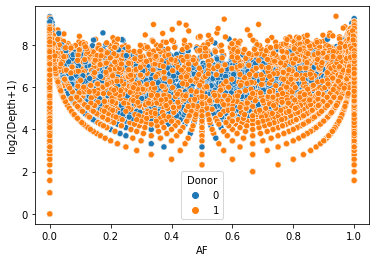

In [11]:
AF_melt = pd.merge(AF_df.reset_index().melt(id_vars="Cell",value_name="AF"),
                   DP_df.reset_index().melt(id_vars="Cell",value_name="DP"), on=["Cell", "variable"])
AF_melt["Donor"] = AF_melt["Cell"].map(cells_meta[ "donor"])
AF_melt["log2_depth"] = np.log2(AF_melt["DP"]+1)
AF_melt

sns.scatterplot(data=AF_melt, x="AF", y="log2_depth", hue="Donor")
plt.xlabel("AF")
plt.ylabel("log2(Depth+1)")
plt.savefig(f"{out_f}.all_variants.png")

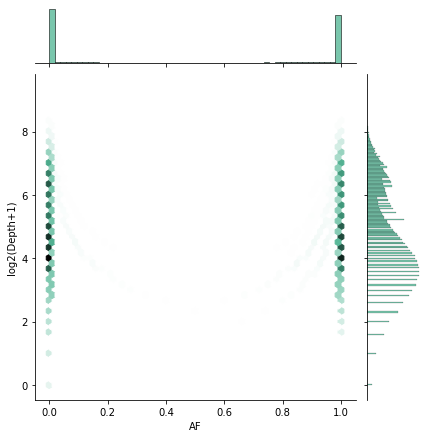

In [12]:
sns.jointplot(x=AF_df.values.flatten(), y=np.log2(DP_df.values.flatten()+1), 
              kind="hex", color="#4CB391")
plt.xlabel("AF")
plt.ylabel("log2(Depth+1)")
plt.savefig(f"{out_f}.all_variants_hex.png")

## Variant-specific

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


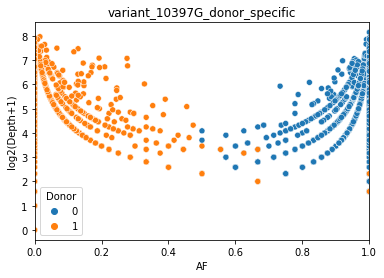

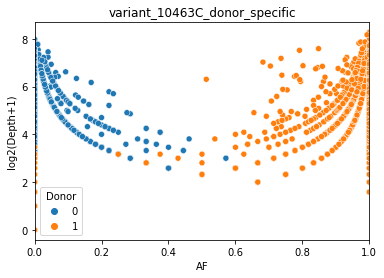

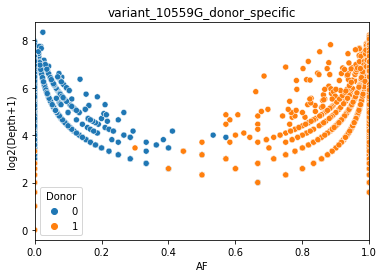

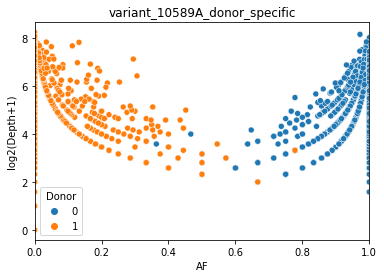

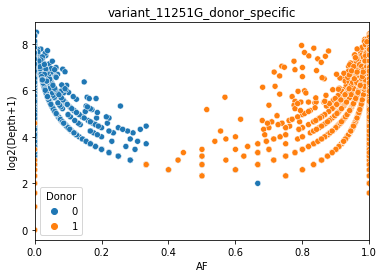

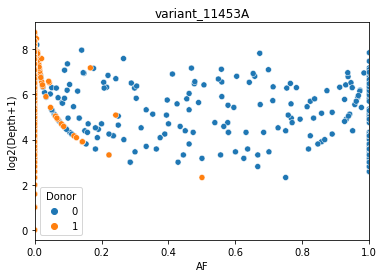

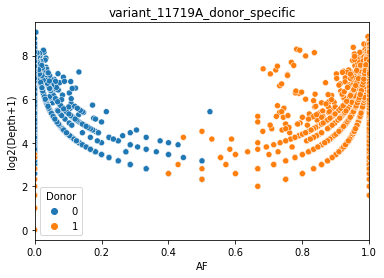

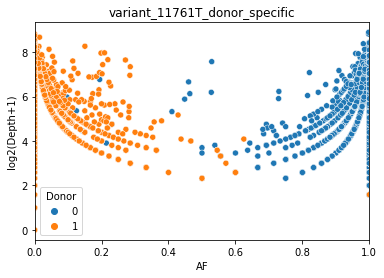

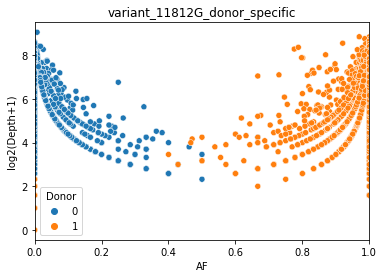

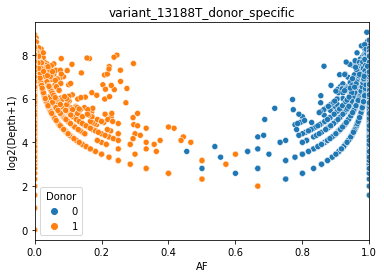

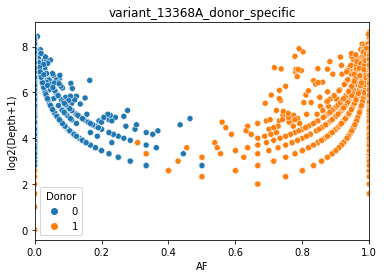

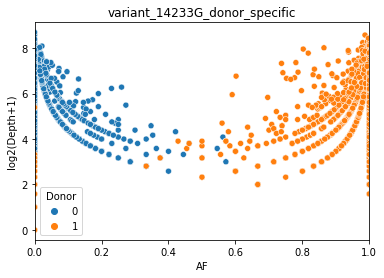

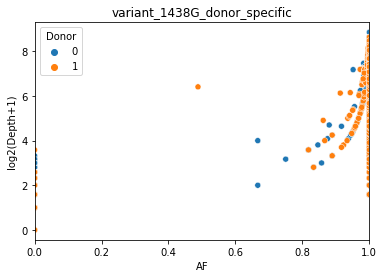

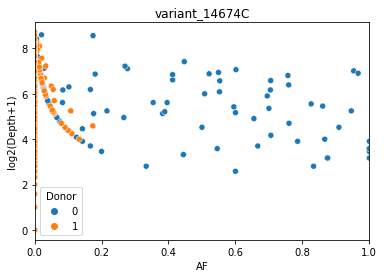

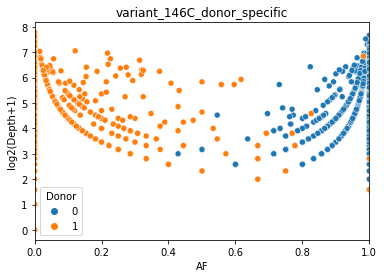

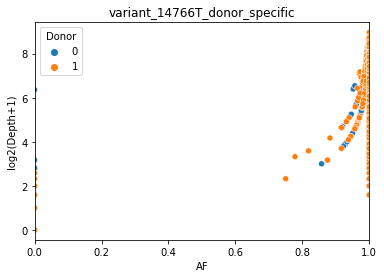

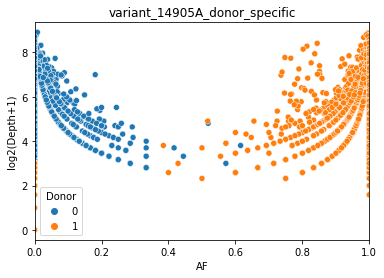

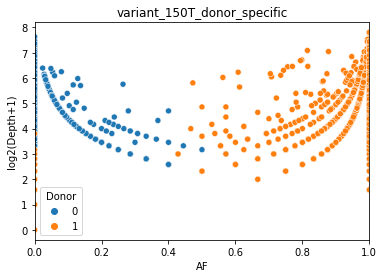

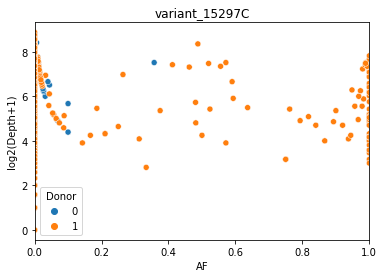

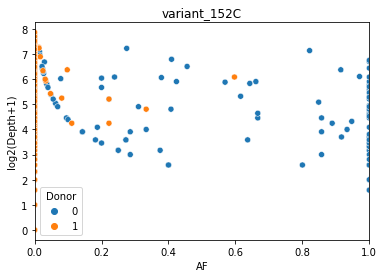

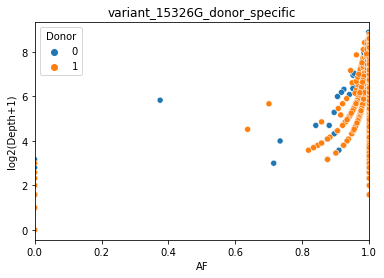

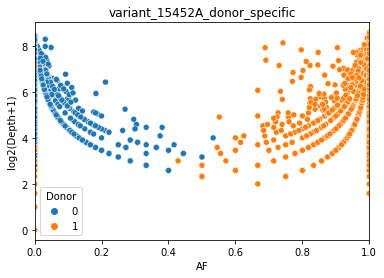

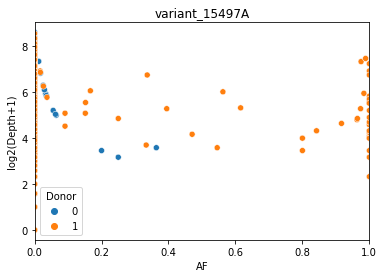

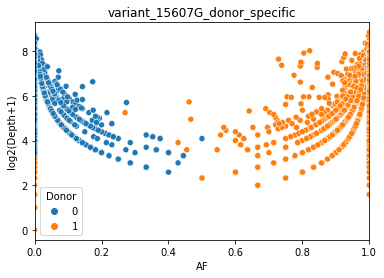

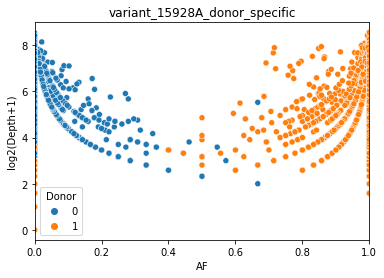

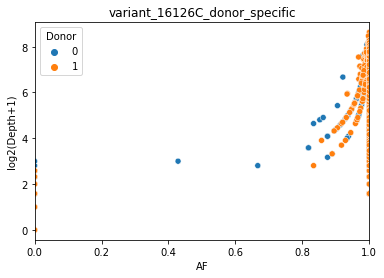

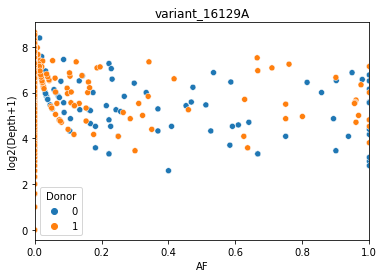

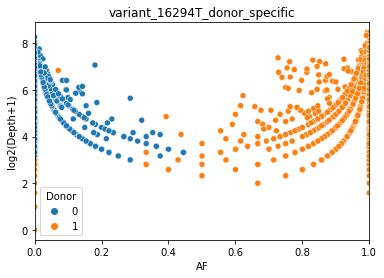

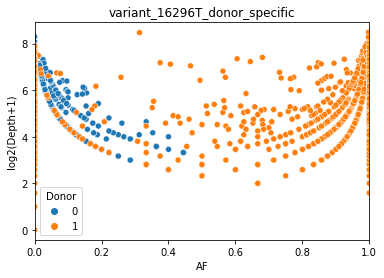

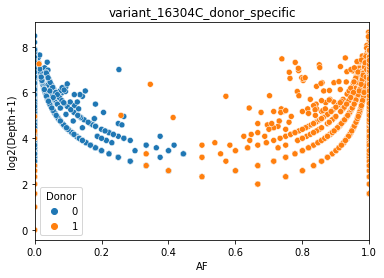

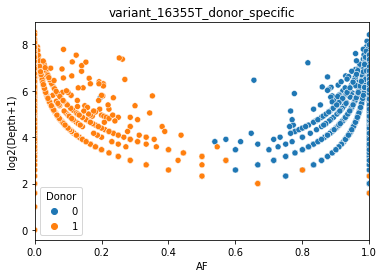

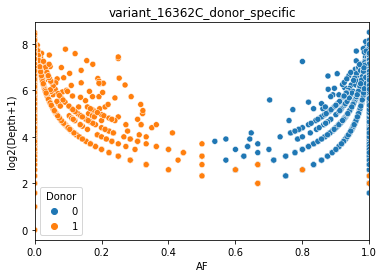

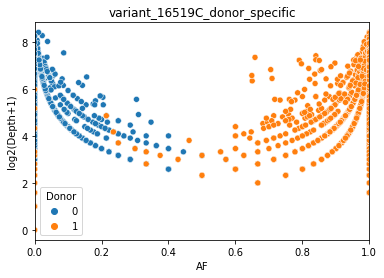

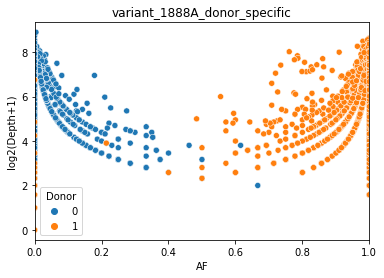

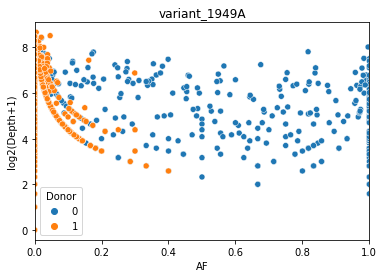

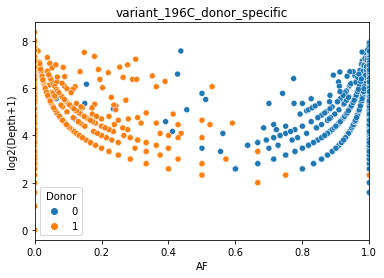

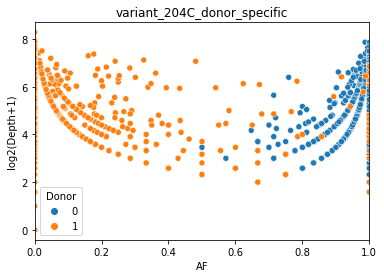

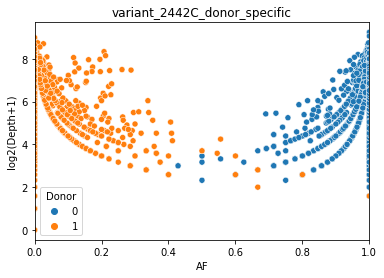

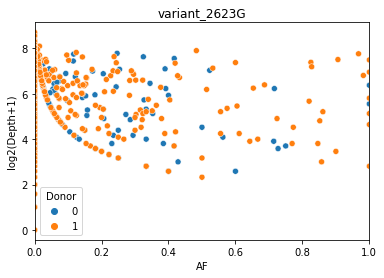

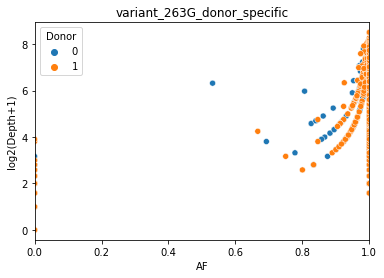

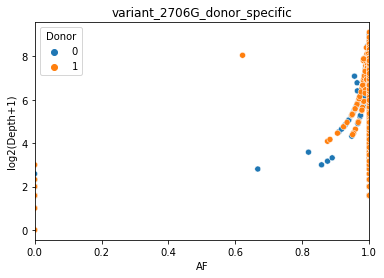

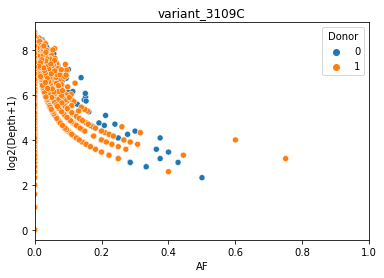

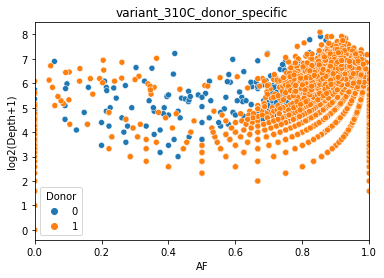

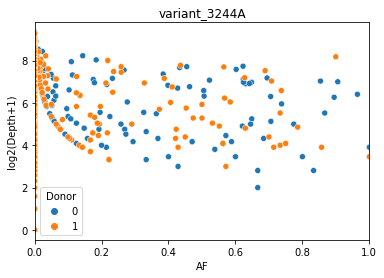

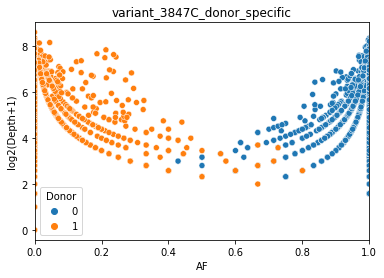

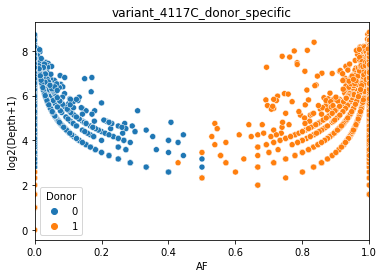

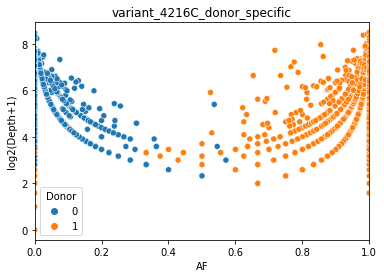

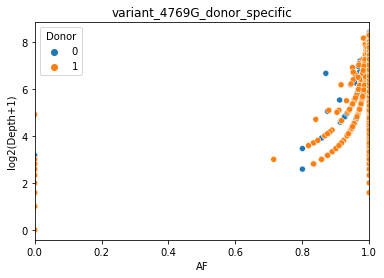

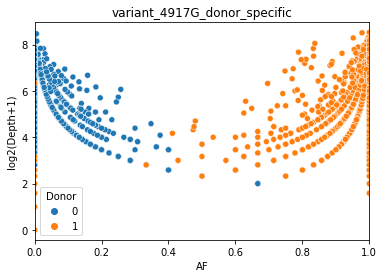

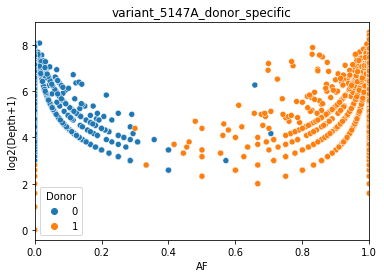

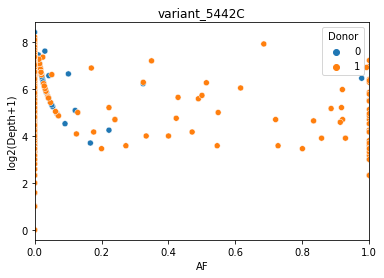

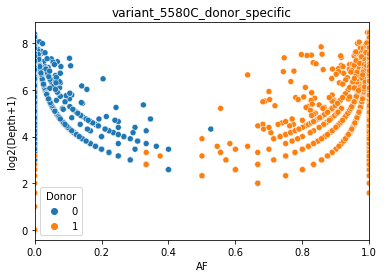

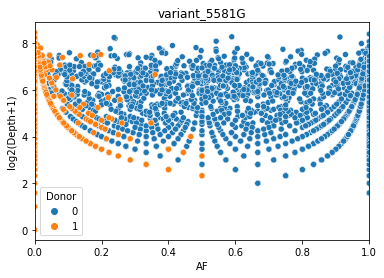

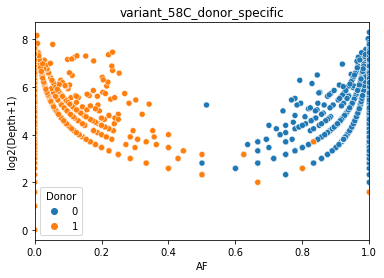

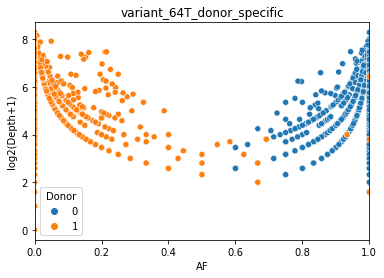

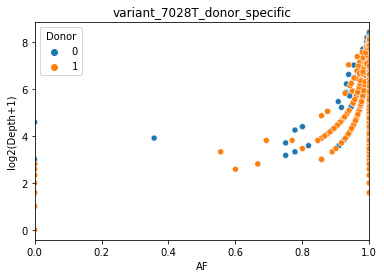

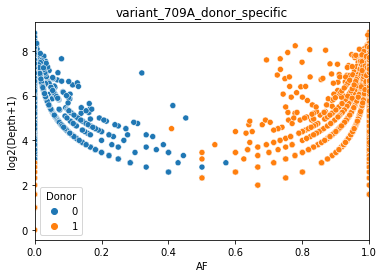

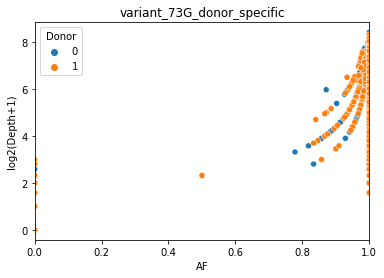

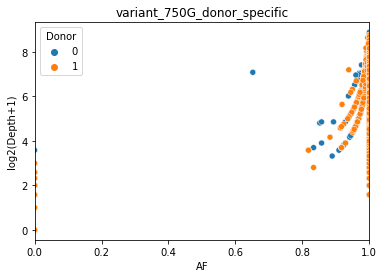

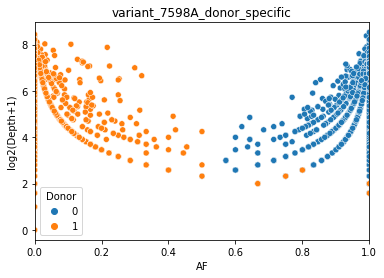

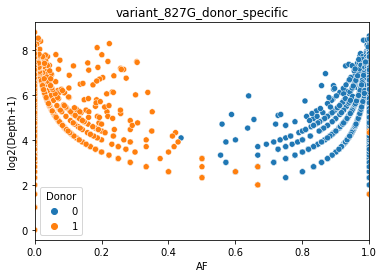

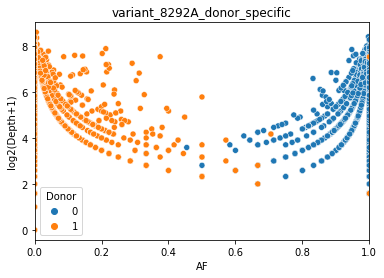

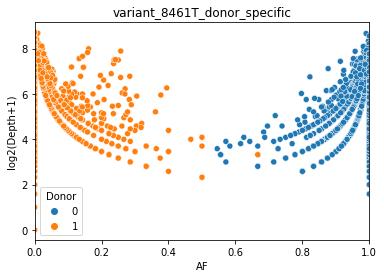

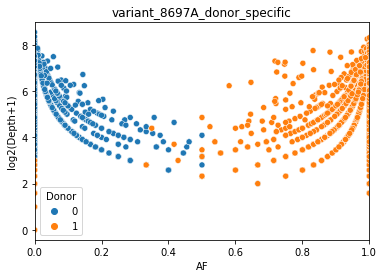

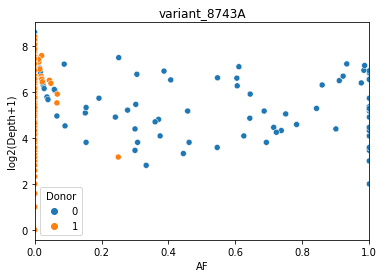

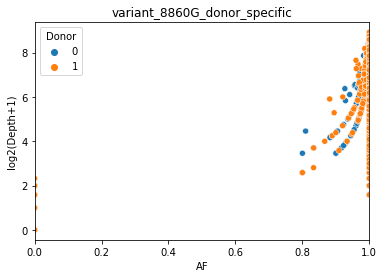

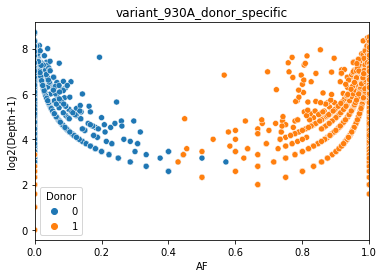

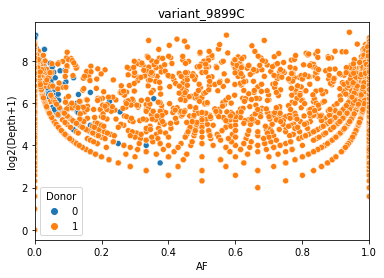

In [13]:
for variant in AF_df.columns:
    f = plt.figure()
    curr_var = pd.DataFrame({"AF": AF_df[variant], "AF_sqrt": np.sqrt(AF_df[variant]),
                             "log2_depth": np.log2(DP_df+1).loc[AF_df.index,variant], "Donor":cells_meta.loc[AF_df.index, "donor"]})
    
    sns.scatterplot(data=curr_var, x="AF", y="log2_depth", hue="Donor")
    plt.xlabel("AF")
    plt.ylabel("log2(Depth+1)")
    
    title = f"variant_{variant}"
    for d in donor_inds:
        if variant in donor_inds[d]:
            title = f"variant_{variant}_donor_specific"
            break
        
    plt.title(title)
    plt.xlim([0,1])    
    plt.savefig(f"{out_f}.{variant}.png")
    
#     for d in curr_var["Donor"].astype(int).astype(str).unique():
#         f = plt.figure()
#         plt.hexbin(x=curr_var[curr_var["Donor"]==d]["AF_sqrt"], y=curr_var[curr_var["Donor"]==d]["DP"]) 
#                    #ax=ax[int(d)])
#         plt.title(f"Donor {d}")
#         plt.xlabel("AF_sqrt")
#         plt.ylabel("log2(Depth+1)")
#         plt.savefig(f"{out_f}._{variant}.png")
